<center>
    <p style="text-align:center">
        <img alt="phoenix logo" src="https://storage.googleapis.com/arize-phoenix-assets/assets/phoenix-logo-light.svg" width="200"/>
        <br>
        <a href="https://arize.com/docs/phoenix/">Docs</a>
        |
        <a href="https://github.com/Arize-ai/phoenix">GitHub</a>
        |
        <a href="https://arize-ai.slack.com/join/shared_invite/zt-2w57bhem8-hq24MB6u7yE_ZF_ilOYSBw#/shared-invite/email">Community</a>
    </p>
</center>

# Multilingual Text2Cypher for Indian Languages

Our evaluation pipeline uses Phoenix to provide comprehensive observability across the entire multilingual evaluation process. Starting with English text-to-Cypher pairs from Neo4j's dataset, we translate questions to target languages and test whether models can generate correct Cypher from non-English inputs. Here's what makes this approach powerful:

End-to-end tracking of English → translation → Cypher generation chains
Translation quality assessment using back-translation and semantic similarity
Cross-lingual Cypher accuracy comparison against English ground truth
Rich metadata capture for detailed failure analysis
Automated evaluation uploads for team collaboration

Let's get started!

In [ ]:
# Install required packages
!pip install dspy-ai
!pip install pandas
!pip install datasets
!pip install sentence-transformers
!pip install openinference-instrumentation-dspy
!pip install openinference-instrumentation
!pip install opentelemetry-api
!pip install opentelemetry-sdk
!pip install litellm openinference-instrumentation-litellm
!pip install arize-phoenix-otel
!pip install arize-phoenix-client


1.   ***We begin by importing all necessary libraries.***

In [ ]:
import dspy
import pandas as pd
from phoenix.otel import register
from openinference.instrumentation.dspy import DSPyInstrumentor
#from openinference.instrumentation.litellm import LiteLLMInstrumentor
from datasets import load_dataset
from sentence_transformers import SentenceTransformer, util
from openinference.semconv.trace import SpanAttributes
from openinference.instrumentation import suppress_tracing
from phoenix.client import Client
from opentelemetry.trace import Status, StatusCode
from opentelemetry.trace import format_span_id
from google.colab import userdata
import os


# Global Configuration
Next, we define the main configuration parameters for our evaluation. This includes the size of the dataset to use and the list of languages we want to translate the questions into. We also define the language models that will be evaluated.

In [3]:
os.environ['PHOENIX_CLIENT_HEADERS'] = userdata.get('PHOENIX_CLIENT_HEADERS')
os.environ['PHOENIX_COLLECTOR_ENDPOINT']= userdata.get('PHOENIX_COLLECTOR_ENDPOINT')
os.environ['OTEL_EXPORTER_OTLP_HEADERS']= userdata.get('OTEL_EXPORTER_OTLP_HEADERS')


PROJECT_NAME = "neo4j-multilingual-eval-v5"

# Configuration for the evaluation run
CONFIG = {
    "dataset_size": 10,
    "target_languages": ["Hindi", "Tamil", "Telugu"]
}

# Define all models to be evaluated
# Note: Ensure the API base URL is correct for your local model server.
# For google collab: We are using openAI, but actual impl was done with gpt-oss-20b
models_to_evaluate = [
    # {
    #     "name": "openai/gpt-oss-20b",
    #     "instance": dspy.LM(model='openai/gpt-oss-20b', api_base="http://localhost:1234/v1"),
    #     "api_key_env": "OPENAI_API_KEY"
    # }
      {
        "name": "openai/gpt-4o-mini",
        "instance": dspy.LM(model='openai/gpt-4o-mini', api_key=userdata.get('OPENAI_API_KEY'))
      }

]

# Define Initialization and Validation Functions
These helper functions will initialize the Phoenix tracer for observability and validate that the necessary API keys are available in the environment.

In [4]:
def init_phoenix():
    """Initialize Phoenix UI for observability."""
    tracer_provider = register(
        project_name=PROJECT_NAME,
        endpoint="https://app.phoenix.arize.com/v1/traces",
        batch=True,
        auto_instrument=True
    )

    tracer = tracer_provider.get_tracer(__name__)
    DSPyInstrumentor().instrument(tracer_provider=tracer_provider)

    #LiteLLMInstrumentor().instrument(tracer_provider=tracer_provider)

    print("DSPy instrumentation enabled")

    client = Client(base_url=userdata.get('PHOENIX_COLLECTOR_ENDPOINT'), api_key=userdata.get('PHOENIX_API_KEY'))
    return tracer, client

# Define Resource Loading Function
This function handles loading the text2cypher dataset from Hugging Face and the sentence-transformer model, which will be used to calculate semantic similarity for translation quality.

In [5]:
def load_resources():
    """Load dataset and sentence model."""
    print("Loading text2cypher dataset")
    ds = load_dataset("neo4j/text2cypher-2024v1")
    train_samples = ds['train'].select(range(CONFIG["dataset_size"]))
    print(f"Dataset loaded with {len(train_samples)} samples")

    print("Loading sentence-transformer model for semantic scoring")
    # Using all-MiniLM-L6-v2, a fast and effective model
    sentence_model = SentenceTransformer('all-MiniLM-L6-v2')
    print("Sentence model loaded successfully")

    return train_samples, sentence_model

# Define DSPy Signatures and Pipeline Module
Here we define the core components of our LLM pipeline using DSPy's signature system.

* Translate: Translates a source text to a target language.

* GenerateCypher: Creates a Cypher query from a natural language question and a database schema.

* EvaluateCypherEquivalence: An LLM-based judge to assess if two Cypher queries are functionally equivalent.

* FullPipelineEvaluator: A dspy.Module that chains the translation and Cypher generation steps together.

In [6]:
class Translate(dspy.Signature):
    """Translates text into a target language."""
    source_text = dspy.InputField(desc="The question in source language")
    target_language = dspy.InputField(desc="Name of the language")
    translated_text = dspy.OutputField(desc="The question in the target language.")


class GenerateCypher(dspy.Signature):
    """Generates a Cypher query from a question and schema."""
    question = dspy.InputField(desc="Natural Language Question")
    neo4j_schema = dspy.InputField(desc="Neo4J schema")
    cypher_query = dspy.OutputField(desc="Generated Cypher Query")


class EvaluateCypherEquivalence(dspy.Signature):
    """Determines if two Cypher queries are functionally equivalent using categorical assessment."""
    ground_truth_query = dspy.InputField(desc="The correct/reference Cypher query")
    generated_query = dspy.InputField(desc="The generated Cypher query to evaluate")
    natural_lang_query = dspy.InputField(desc="Natural Language Query in english")
    neo4j_schema = dspy.InputField(desc="Neo4j database schema for context")
    equivalence_category = dspy.OutputField(desc="One of: EQUIVALENT, PARTIALLY_CORRECT, INCORRECT, SYNTAX_ERROR")
    reasoning = dspy.OutputField(desc="Brief explanation of the categorization")


class FullPipelineEvaluator(dspy.Module):
    """A DSPy module that runs the translation and Cypher generation steps."""
    def __init__(self):
        super().__init__()
        self.translator = dspy.Predict(Translate)
        self.cypher_generator = dspy.Predict(GenerateCypher)

    def forward(self, question, schema, target_language):
        print(f"Running pipeline for question: {question[:50]}...")

        # 1. Get translation
        t = self.translator(source_text=question, target_language=target_language)
        print(f"Translation completed: {t.translated_text[:50]}...")

        # 2. Generate cypher from translated question
        c = self.cypher_generator(question=t.translated_text, neo4j_schema=schema)
        print(f"Cypher generation completed: {c.cypher_query[:50]}...")

        return dspy.Prediction(
            translated_question=t.translated_text,
            generated_query=c.cypher_query
        )

# Define Evaluation Functions
These functions are responsible for scoring the outputs of the pipeline.

* score_translation_quality: Uses back-translation and semantic similarity to score the quality of the translation.

* compare_query_results_with_llm: Uses the EvaluateCypherEquivalence judge to score the correctness of the generated Cypher query.

* safe_set_span_attributes: A utility to safely add attributes to OpenTelemetry spans for tracing.

In [7]:
def score_translation_quality(original_text, translated_text, back_translator, sentence_model):
    """Performs back-translation and returns a semantic similarity score."""
    print("Evaluating translation quality")
    with suppress_tracing():
        try:
            back_translation_result = back_translator(
                source_text=translated_text,
                target_language="English"
            )
            back_translated_text = back_translation_result.translated_text

            embedding_1 = sentence_model.encode(original_text, convert_to_tensor=True)
            embedding_2 = sentence_model.encode(back_translated_text, convert_to_tensor=True)

            similarity_score = util.pytorch_cos_sim(embedding_1, embedding_2).item()
            print(f"Translation quality score: {similarity_score:.3f}")

            return {"score": similarity_score, "back_translated_text": back_translated_text}
        except Exception as e:
            print(f"Error in translation quality evaluation: {e}")
            return {"score": 0.0, "back_translated_text": "", "error": str(e)}


def compare_query_results_with_llm(ground_truth_query, generated_query, schema, cypher_judge, natural_language_question):
    """Compare queries using a categorical LLM judge."""
    print("Comparing queries using categorical LLM judge")
    try:
        result = cypher_judge(
            ground_truth_query=ground_truth_query,
            generated_query=generated_query,
            neo4j_schema=schema,
            natural_lang_query=natural_language_question
        )

        category = result.equivalence_category.upper()

        if category == "EQUIVALENT":
            correct, score = True, 1.0
        elif category == "PARTIALLY_CORRECT":
            correct, score = None, 0.5  # Partial credit
        else: # INCORRECT, SYNTAX_ERROR, or other
            correct, score = False, 0.0

        return {"correct": correct, "category": category, "score": score, "reason": result.reasoning}

    except Exception as e:
        print(f"Error in LLM judge evaluation: {e}")
        return {"correct": False, "category": "ERROR", "score": 0.0, "reason": f"Judge evaluation error: {e}"}

def safe_set_span_attributes(span, attributes):
    """Safely set span attributes without causing warnings."""
    if span and span.is_recording():
        try:
            span.set_attributes(attributes)
        except Exception as e:
            print(f"Could not set span attributes: {e}")

# Define Core Sample Processing Function
This is the main orchestration function. For a single data sample, it runs the full pipeline, evaluates the results, and records everything in a custom OpenTelemetry span that will be visible in Phoenix.

In [8]:
def process_and_evaluate_sample(tracer, sample, evaluator, back_translator, sentence_model, target_language, cypher_judge, sample_id):
    """Main function to process one sample, orchestrating all steps."""
    print(f"Processing sample {sample_id} for language {target_language}")

    with tracer.start_as_current_span(
        f"multilingual_evaluation_{target_language}",
        openinference_span_kind="chain",
        attributes={"evaluation.sample_id": str(sample_id)}
    ) as eval_span:
        try:
            # Run the full translation and cypher generation pipeline
            print(f"Original Question (English): {sample['question']}")
            pipeline_result = evaluator(
                question=sample['question'],
                schema=sample['schema'],
                target_language=target_language
            )
            print(f"Translated Question ({target_language}): {pipeline_result.translated_question}")

            # Evaluate translation quality
            translation_score_result = score_translation_quality(
                sample['question'], pipeline_result.translated_question,
                back_translator, sentence_model
            )

            # Evaluate Cypher query correctness
            cypher_assessment = compare_query_results_with_llm(
                sample['cypher'], pipeline_result.generated_query, sample['schema'],
                cypher_judge, sample['question']
            )

            # Set all evaluation results as attributes on the span
            evaluation_attrs = {
                "evaluation.translation_score": float(translation_score_result.get('score', 0.0)),
                "evaluation.cypher_correct": cypher_assessment.get('correct'),
                "evaluation.cypher_category": cypher_assessment.get('category', ''),
                "evaluation.cypher_score": cypher_assessment.get('score', 0.0),
                "evaluation.cypher_reason": cypher_assessment.get('reason', ''),
                "evaluation.ground_truth_query": sample['cypher'],
                "evaluation.generated_query": pipeline_result.generated_query,
                "evaluation.original_text": sample['question'],
                "evaluation.translated_text": pipeline_result.translated_question,
                SpanAttributes.INPUT_VALUE: pipeline_result.translated_question,
                SpanAttributes.OUTPUT_VALUE: pipeline_result.generated_query,
            }
            safe_set_span_attributes(eval_span, evaluation_attrs)
            eval_span.set_status(Status(StatusCode.OK))
            span_id = format_span_id(eval_span.get_span_context().span_id)

            print(f"Sample {sample_id} evaluation completed successfully")
            return pipeline_result, translation_score_result, cypher_assessment, span_id

        except Exception as e:
            print(f"Error processing sample {sample_id}: {e}", exc_info=True)
            safe_set_span_attributes(eval_span, {"error": str(e)})
            eval_span.set_status(Status(StatusCode.ERROR, description=str(e)))
            span_id = format_span_id(eval_span.get_span_context().span_id)
            return None, {"score": 0.0, "error": str(e)}, {"correct": False, "reason": f"Pipeline error: {e}"}, span_id

# Initialize and Run the Full Evaluation
This is the main execution block. We initialize Phoenix, validate keys, and load our data. Then, we loop through each model, each target language, and each sample in our dataset, calling the processing function defined above and collecting the results.

In [9]:
# 1. Initialize Phoenix and validate setup
tracer, client = init_phoenix()

# 2. Load dataset and sentence model
train_samples, sentence_model = load_resources()

all_results = []

# 3. Main evaluation loop
for model_config in models_to_evaluate:
    model_name = model_config['name']
    llm_instance = model_config['instance']

    print(f"--- Evaluating Model: {model_name} ---")
    dspy.settings.configure(lm=llm_instance)

    # Initialize DSPy components for this model
    evaluator = FullPipelineEvaluator()
    back_translator = dspy.Predict(Translate)
    cypher_judge = dspy.Predict(EvaluateCypherEquivalence)

    for target_language in CONFIG["target_languages"]:
        print(f"--- Testing language: {target_language} ---")

        for i, sample in enumerate(train_samples):
            print(f"Processing sample {i+1}/{len(train_samples)} for {target_language}")

            pipeline_result, translation_score, cypher_assessment, span_id = process_and_evaluate_sample(
                tracer=tracer, sample=sample, evaluator=evaluator,
                back_translator=back_translator, sentence_model=sentence_model,
                target_language=target_language, cypher_judge=cypher_judge, sample_id=i
            )

            # Add annotations to the span in Phoenix
            try:
                client.annotations.add_span_annotation(
                    annotation_name="translation_score", annotator_kind="LLM", span_id=span_id,
                    label="translation", score=float(translation_score.get('score', 0.0))
                )
                client.annotations.add_span_annotation(
                    annotation_name="cypher_score", annotator_kind="LLM", span_id=span_id,
                    label="cypher", score=cypher_assessment.get('score', 0.0),
                    metadata={"category": cypher_assessment.get('category', '')}
                )
            except Exception as e:
                print(f"Failed to push annotations for span {span_id}: {e}")

            # Store results for final summary report
            result = {
                "model_name": model_name, "sample_id": i, "question": sample['question'],
                "target_language": target_language, "translation_score": translation_score.get('score', 0.0),
                "is_correct": cypher_assessment.get('correct'), "cypher_category": cypher_assessment.get('category'),
                "cypher_score": cypher_assessment.get('score', 0.0), "reason": cypher_assessment.get('reason'),
                "has_error": 'error' in translation_score or 'error' in cypher_assessment
            }
            if pipeline_result:
                result.update({
                    "translated_question": pipeline_result.translated_question,
                    "generated_query": pipeline_result.generated_query
                })
            all_results.append(result)

print("--- Full evaluation run complete. ---")

🔭 OpenTelemetry Tracing Details 🔭
|  Phoenix Project: neo4j-multilingual-eval-v5
|  Span Processor: BatchSpanProcessor
|  Collector Endpoint: https://app.phoenix.arize.com/v1/traces
|  Transport: HTTP + protobuf
|  Transport Headers: {'api_key': '****'}
|  
|  Using a default SpanProcessor. `add_span_processor` will overwrite this default.
|  
|  `register` has set this TracerProvider as the global OpenTelemetry default.
|  To disable this behavior, call `register` with `set_global_tracer_provider=False`.

DSPy instrumentation enabled
Loading text2cypher dataset
Dataset loaded with 10 samples
Loading sentence-transformer model for semantic scoring
Sentence model loaded successfully
--- Evaluating Model: openai/gpt-4o-mini ---
--- Testing language: Hindi ---
Processing sample 1/10 for Hindi
Processing sample 0 for language Hindi
Original Question (English): Which 3 countries have the most entities linked as beneficiaries in filings?
Running pipeline for question: Which 3 countries have 

/tmp/ipython-input-3436796095.py:36: DeprecationWarning: client.annotations.add_span_annotation() is deprecated. Use client.spans.add_span_annotation() instead.
  client.annotations.add_span_annotation(
/tmp/ipython-input-3436796095.py:40: DeprecationWarning: client.annotations.add_span_annotation() is deprecated. Use client.spans.add_span_annotation() instead.
  client.annotations.add_span_annotation(


Running pipeline for question: What are the names of the first 3 organizations an...
Translation completed: पहली 3 संगठनों के नाम और उनके सीईओ कौन हैं, जहाँ स...
Cypher generation completed: MATCH (o:Organization)<-[:HAS_CEO]-(p:Person)
WHER...
Translated Question (Hindi): पहली 3 संगठनों के नाम और उनके सीईओ कौन हैं, जहाँ संगठन सार्वजनिक नहीं है?
Evaluating translation quality
Translation quality score: 0.986
Comparing queries using categorical LLM judge
Sample 1 evaluation completed successfully
Processing sample 3/10 for Hindi
Processing sample 2 for language Hindi
Original Question (English): List the names of the games played by streams that have a total view count greater than 50,000,000.
Running pipeline for question: List the names of the games played by streams that...
Translation completed: 50,000,000 से अधिक कुल व्यू काउंट वाले स्ट्रीम द्व...
Cypher generation completed: MATCH (s:Stream)-[:PLAYS]->(g:Game)
WHERE s.total_...
Translated Question (Hindi): 50,000,000 से अधिक कुल व

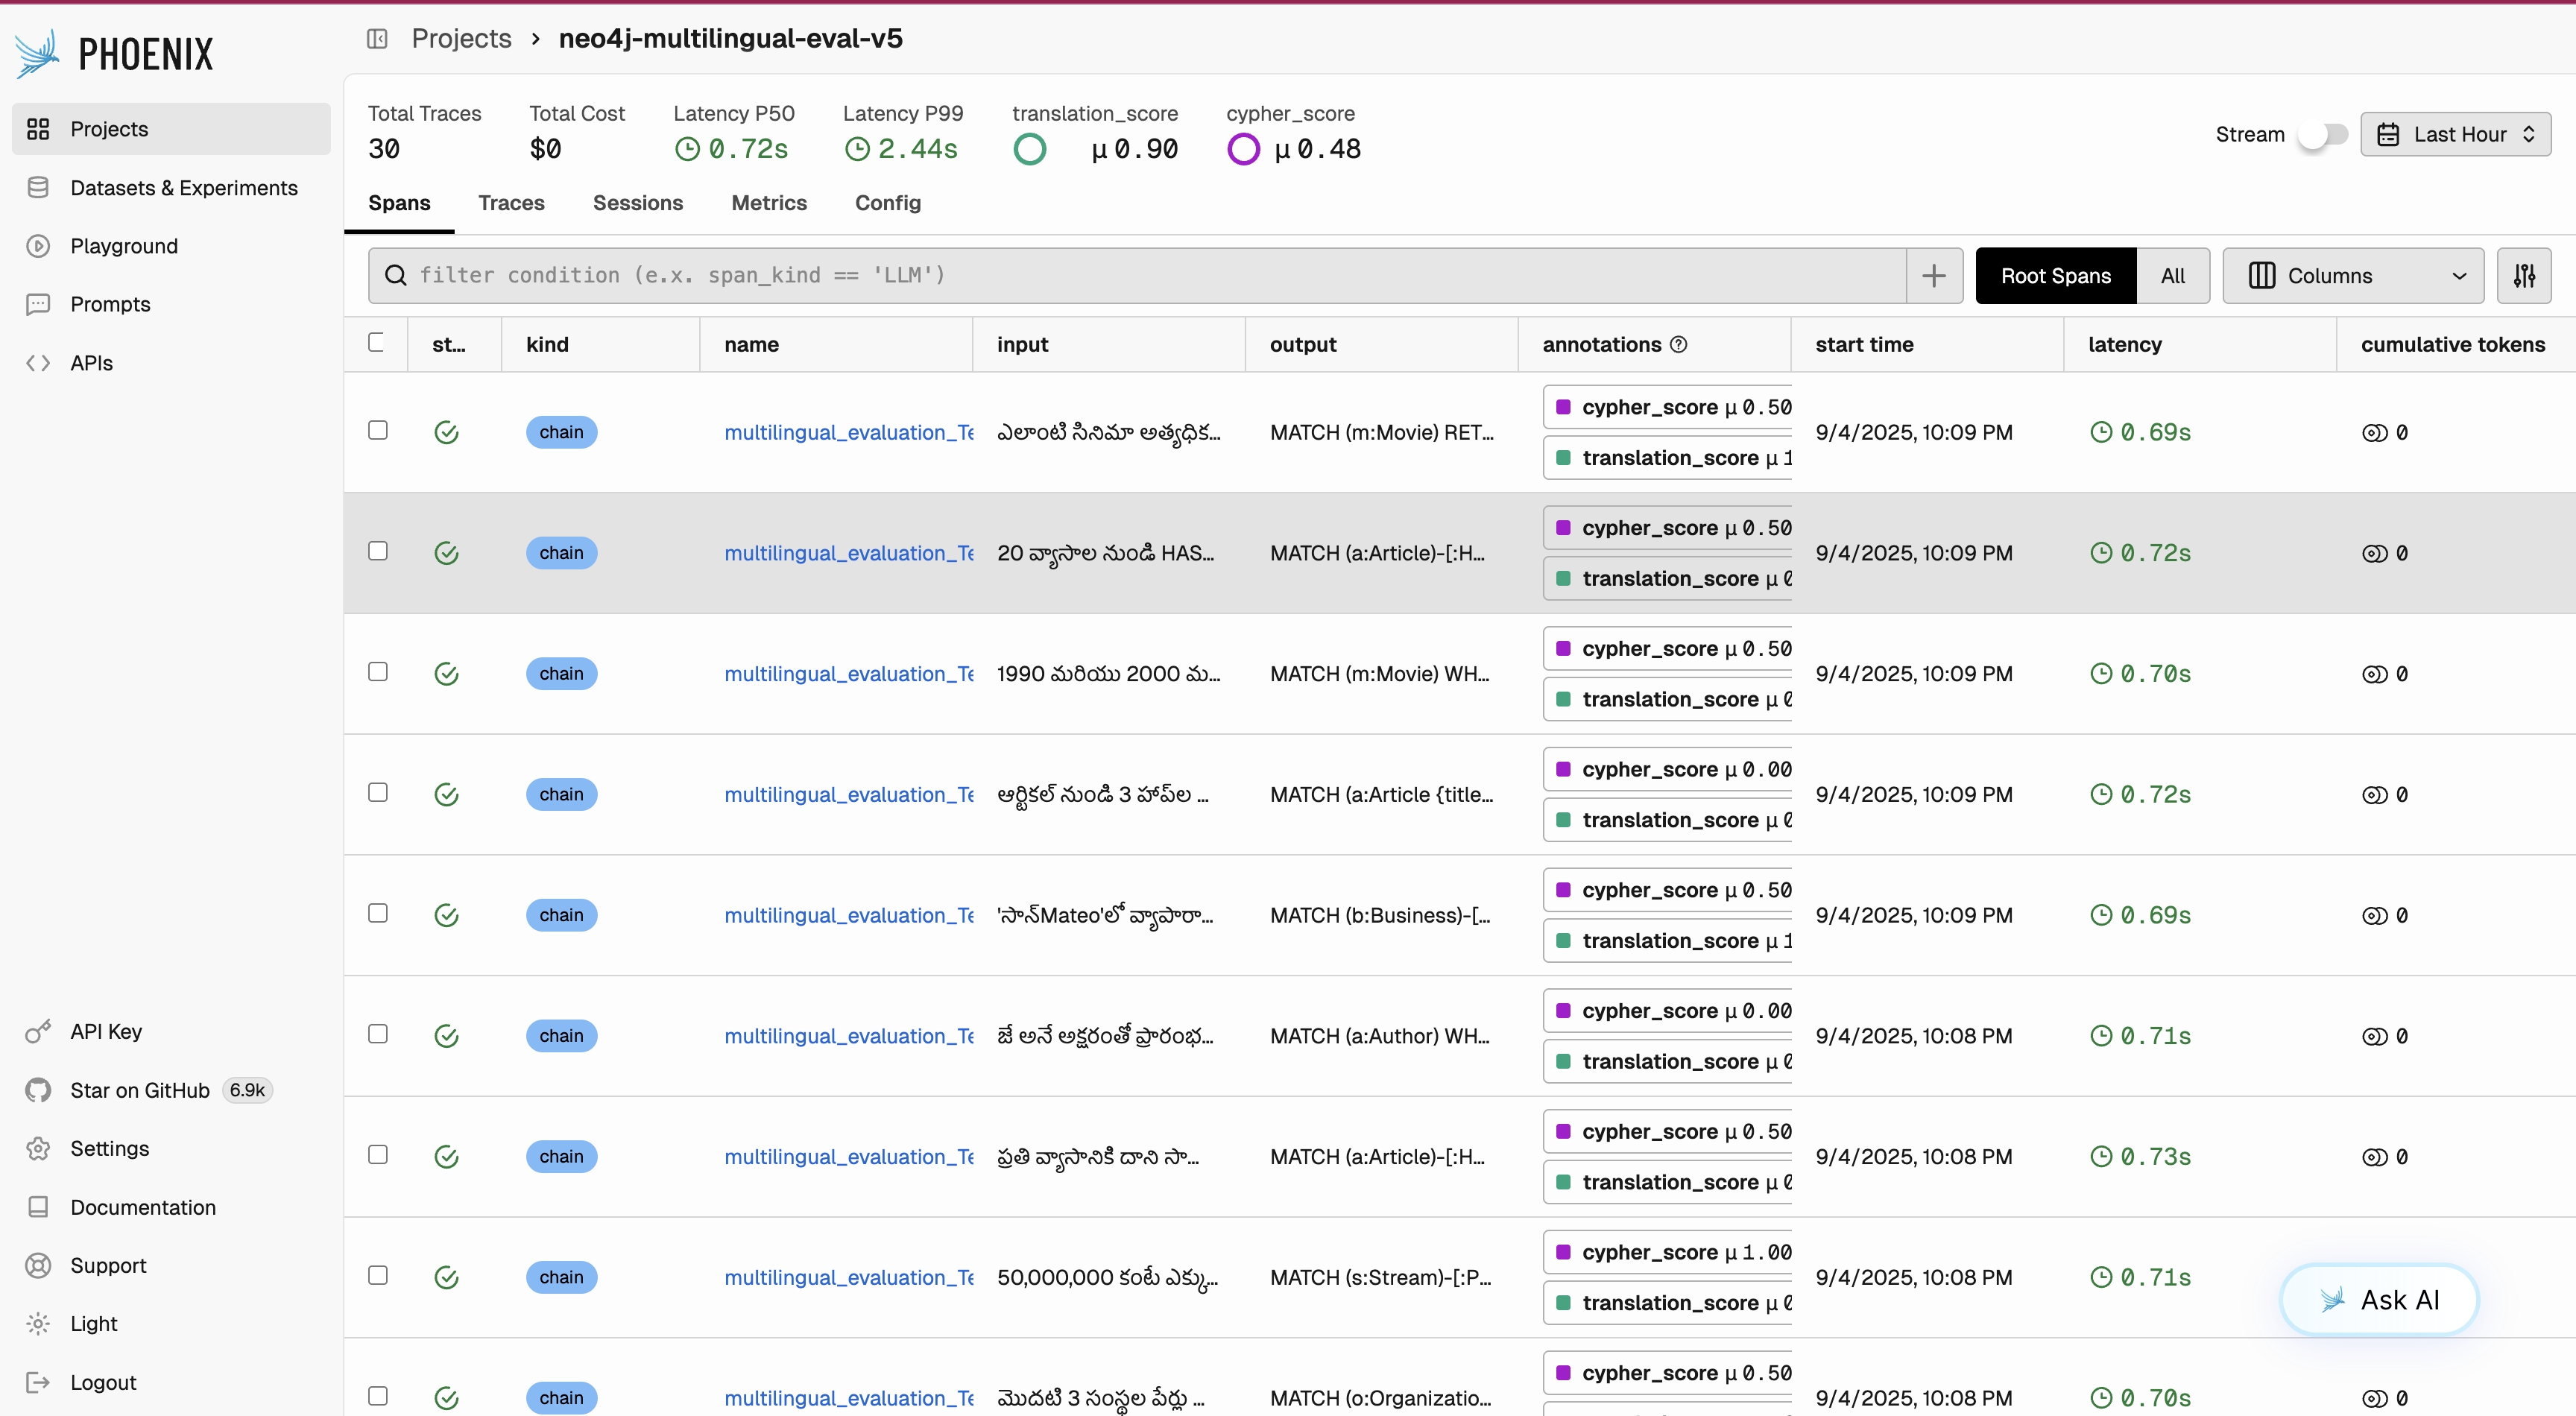

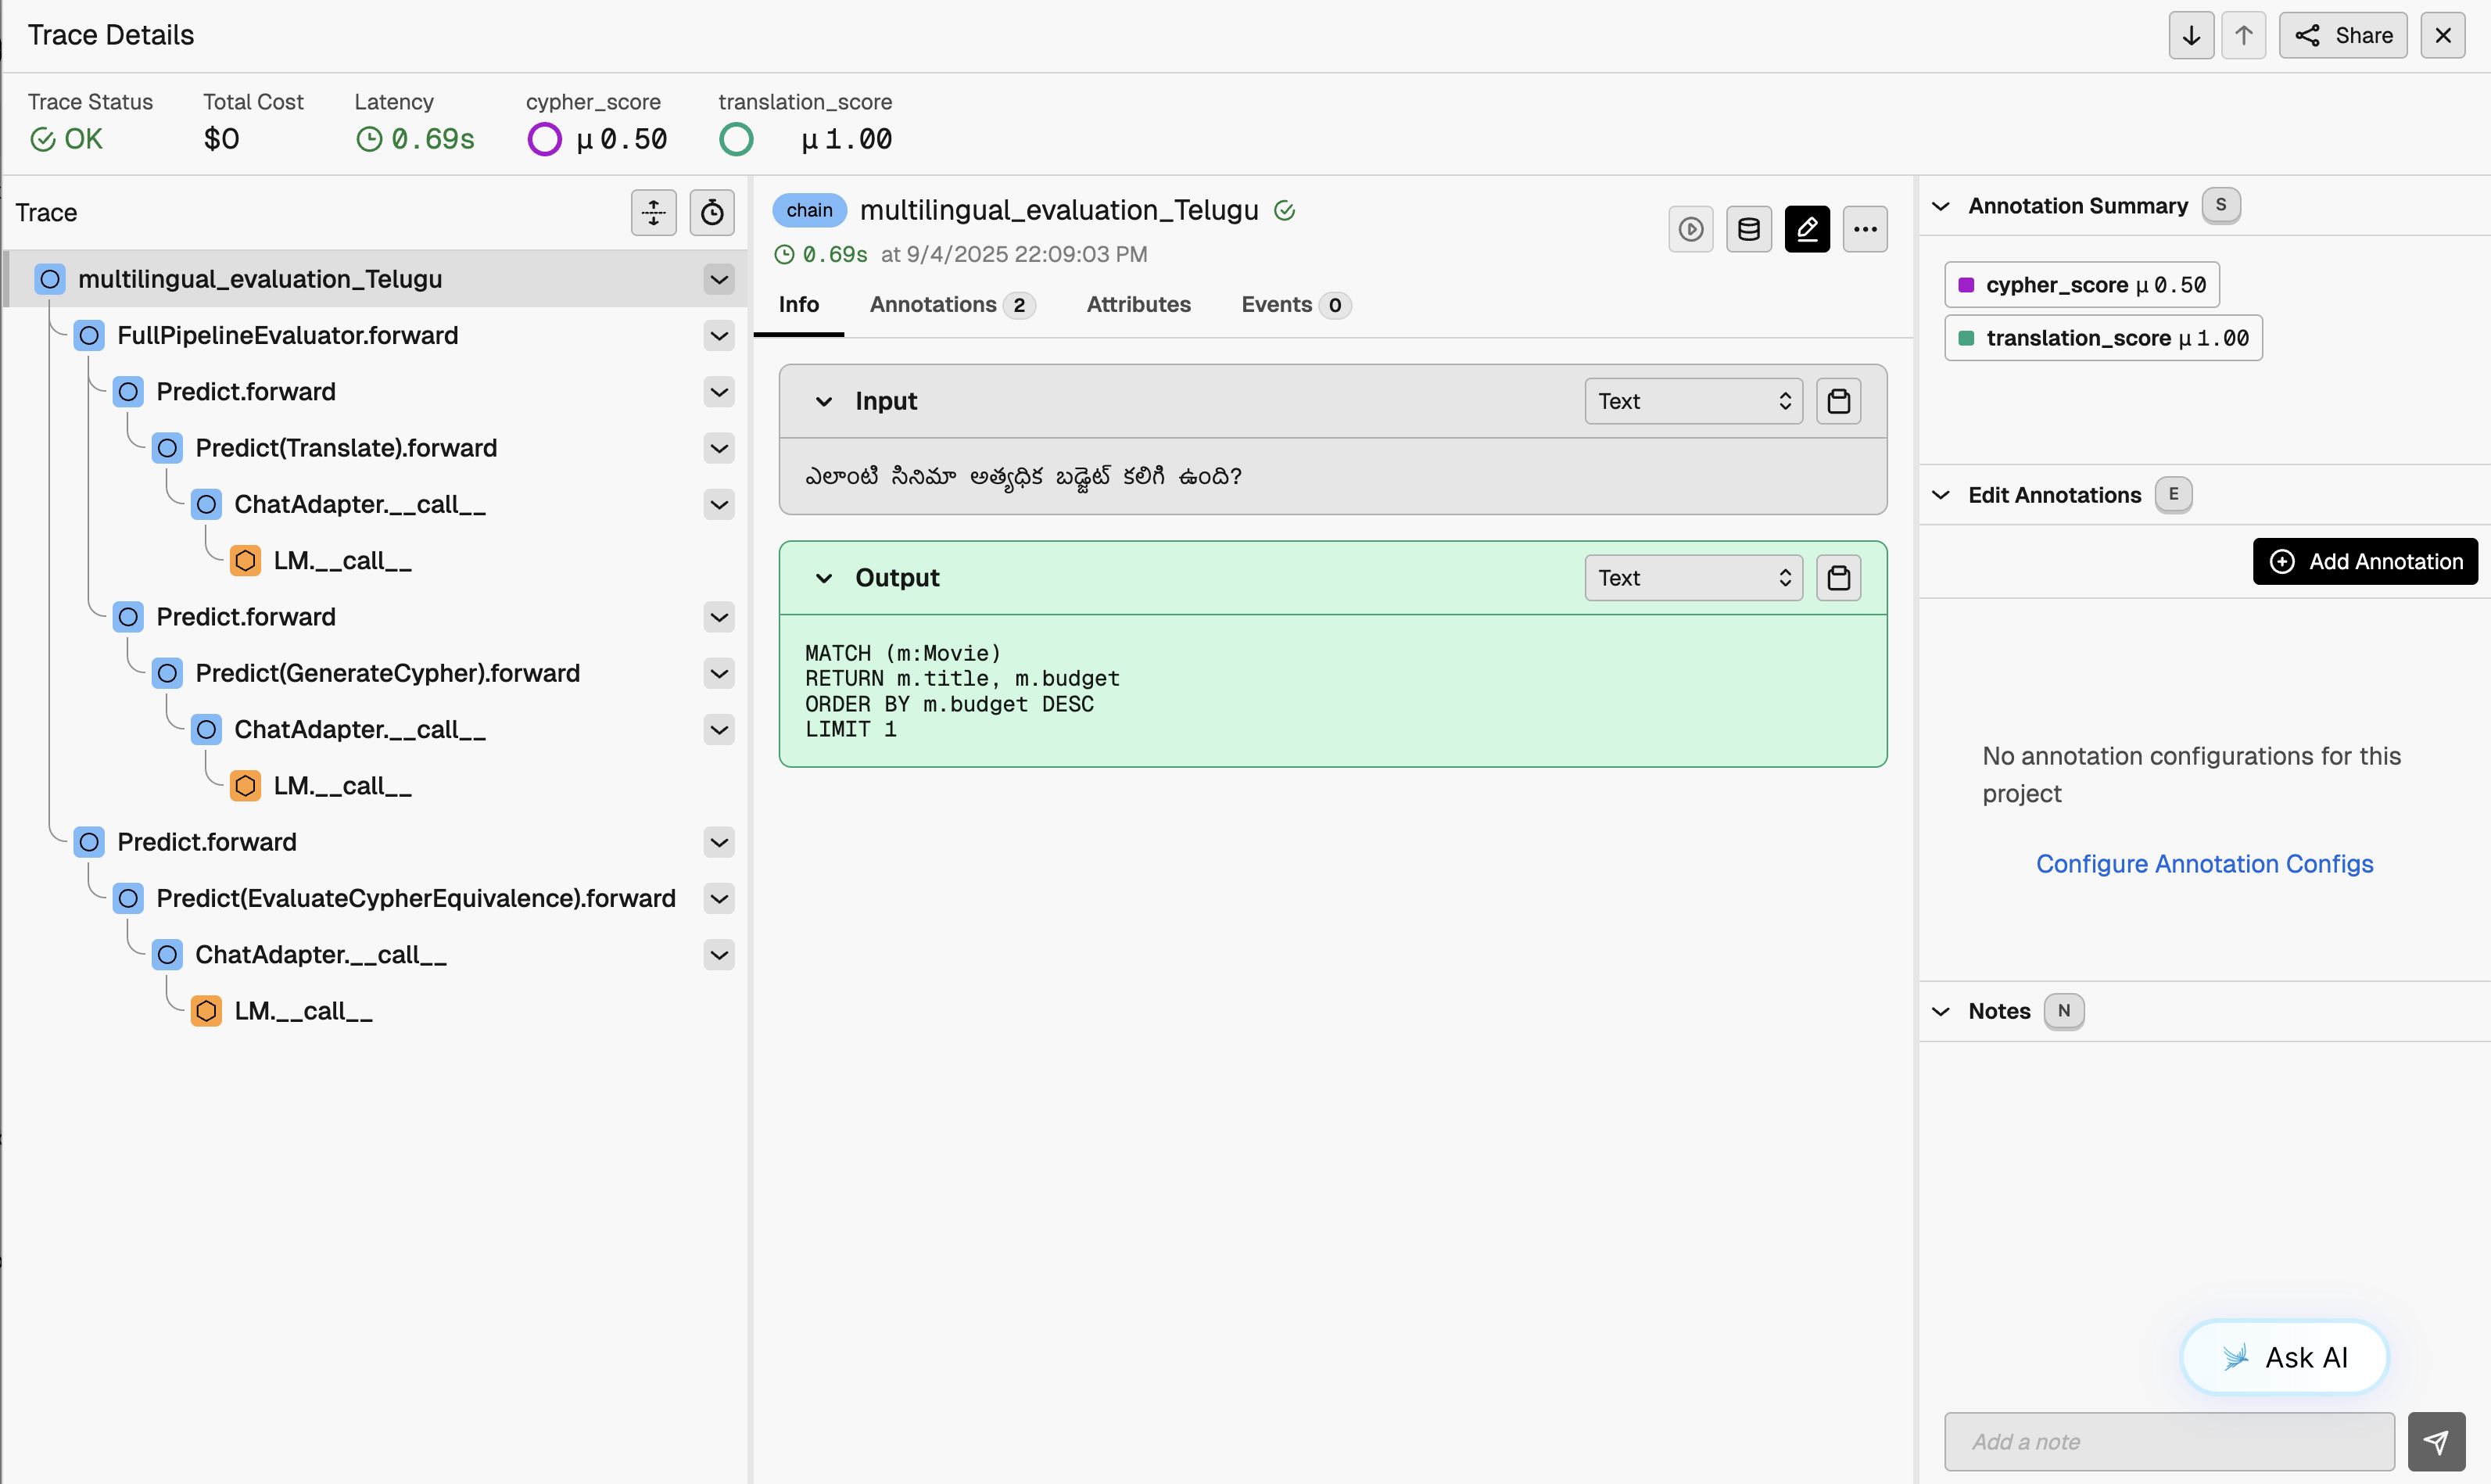